In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import numpy as np
from haversine import haversine
from selenium import webdriver
import folium
import json
import os
import urllib.request
import time

### 성동구, 용산구, 중구 osmnx 노드 추출 후 저장

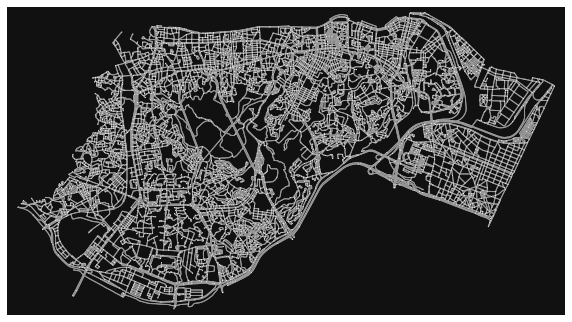

In [2]:
places = ['중구, 서울, 대한민국', '용산구, 서울, 대한민국', '성동구, 서울, 대한민국']
G = ox.graph_from_place(places, network_type = 'walk')
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(G_proj, rebuild_graph = True, tolerance=15, dead_ends=False)
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
fig1, ax = ox.plot_graph(G2, node_size = 1, figsize = (10, 10))

In [3]:
nodes1 = ox.graph_to_gdfs(G2, edges = False)
nodes1               #교차로 제거 노드
df2 = pd.DataFrame(nodes1)
df2 = df2[['osmid_original', 'x', 'y', 'lon', 'lat', 'geometry']]

In [4]:
# geometry 데이터를 좌표변환 후 lat, lon column으로 가져오기
df3 = gpd.GeoDataFrame(df2)
df3_meracator = df3.to_crs(epsg=4326)
df3 = df3_meracator
#geometry 칼럼에서 각 좌표값 가져오기
df3['lon'] = df3.centroid.x
df3['lat'] = df3.centroid.y
df3

C:\Users\LG\AppData\Local\Temp/ipykernel_22960/3528801373.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df3['lon'] = df3.centroid.x
C:\Users\LG\AppData\Local\Temp/ipykernel_22960/3528801373.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df3['lat'] = df3.centroid.y


,osmid_original,x,y,lon,lat,geometry
osmid,,,,,,
0,"[266813237, 3771909762, 436847094, 4597210999,...",323380.176790,4.155191e+06,127.001205,37.526794,POINT (127.00120 37.52679)
1,3771899749,323315.953683,4.155236e+06,127.000468,37.527184,POINT (127.00047 37.52718)
2,"[278159482, 1378780857, 1378780918]",323037.208250,4.155107e+06,126.997346,37.525970,POINT (126.99735 37.52597)
3,1378780898,323106.007991,4.155081e+06,126.998131,37.525748,POINT (126.99813 37.52575)
4,278159676,323485.729411,4.155289e+06,127.002375,37.527696,POINT (127.00238 37.52770)
...,...,...,...,...,...,...
5534,"[8605019071, 8605019075, 8605019078]",328341.156754,4.159121e+06,127.056399,37.563132,POINT (127.05640 37.56313)
5535,8615050247,327109.381889,4.158969e+06,127.042495,37.561535,POINT (127.04250 37.56154)
5536,"[8615050332, 8615050331]",327201.572985,4.159008e+06,127.043529,37.561900,POINT (127.04353 37.56190)


In [5]:
# 결측값 확인
df3.isnull().sum()

osmid_original    0
x                 0
y                 0
lon               0
lat               0
geometry          0
dtype: int64

In [ ]:
# osmnx 노드 저장
df3.to_csv('서울_중구_용산구_성동구_os노드.csv', index = False, encoding = 'CP949')

In [6]:
df_os_intersec = pd.read_csv('서울_중구_용산구_성동구_os노드.csv', encoding = 'CP949')
df_os_intersec = df_os_intersec[['lat', 'lon']]
df_os_intersec

,lat,lon
0,37.526794,127.001205
1,37.527184,127.000468
2,37.525970,126.997346
3,37.525748,126.998131
4,37.527696,127.002375
...,...,...
5534,37.563132,127.056399
5535,37.561535,127.042495
5536,37.561900,127.043529
5537,37.568020,127.029326


### cctv 데이터 전처리

In [7]:
df_jung = pd.read_csv('cctv데이터/서울특별시 중구 (안심이) CCTV 설치 현황.csv', encoding = 'CP949')
df_young = pd.read_csv('cctv데이터/서울특별시 용산구 (안심이) CCTV 설치 현황.csv', encoding = 'CP949')
df_sung = pd.read_csv('cctv데이터/서울특별시 성동구 (안심이) CCTV 설치 현황.csv', encoding = 'CP949')
df_jung = df_jung[['WGS x좌표', 'WGS y좌표']]
df_young = df_young[['WGS x좌표', 'WGS y좌표']]
df_sung = df_sung[['WGS x좌표', 'WGS y좌표']]
df_cctv = pd.concat([df_jung, df_young, df_sung])
df_cctv.columns = ['lat', 'lon']
df_cctv

,lat,lon
0,37.561861,127.978257
1,37.554185,127.014058
2,37.561685,127.020398
3,37.567439,127.017971
4,37.569127,127.022259
...,...,...
1115,37.544518,127.055817
1116,37.544804,127.054794
1117,37.545101,127.054893
1118,37.547386,127.046478


In [8]:
# 결측값 제거 후 확인
df_cctv = df_cctv.dropna(axis = 0)
df_cctv.isnull().sum()

lat    0
lon    0
dtype: int64

In [50]:
# csv파일로 저장
df_cctv.to_csv('중구_용산구_성동구 cctv.csv', encoding = 'CP949')

### 보안등 데이터 전처리

In [9]:
df_jung = pd.read_csv('보안등정보/서울특별시_중구_보안등정보_20210329_1617605529340_860528.csv', encoding = 'CP949')
df_young = pd.read_csv('보안등정보/서울특별시_용산구_보안등정보_20200410.csv', encoding = 'CP949')
df_sung = pd.read_csv('보안등정보/서울특별시_성동구_보안등정보_20210303_1614750964112_910893.csv', encoding = 'CP949')
df_sl = pd.concat([df_jung, df_young, df_sung])
df_sl = df_sl[['위도', '경도']]
df_sl.columns = ['lat', 'lon']
df_sl

,lat,lon
0,37.563500,126.978000
1,37.563500,126.978000
2,37.563100,126.977700
3,37.562900,126.977700
4,37.562900,126.977700
...,...,...
7438,37.558408,127.040481
7439,37.558408,127.040481
7440,37.558408,127.040481
7441,37.558408,127.040481


In [10]:
# 결측값 제거 후 확인
df_sl = df_sl.dropna(axis = 0)
df_sl.isnull().sum()

lat    0
lon    0
dtype: int64

In [49]:
# csv 파일로 저장
df_sl.to_csv('중구_용산구_성동구 보안등.csv', encoding = 'CP949')

### 횡단보도 데이터 전처리

In [11]:
# 나눌 서울시 구 설정 -> 용산구의 경우
korea = gpd.read_file('sum_data/서울시구경계.shp', encoding = 'CP949')
korea = korea[korea['SIGUNGU_NM'] == '용산구']
korea

,BASE_YEAR,SIGUNGU_CD,SIGUNGU_NM,geometry
2,2018,11030,용산구,"POLYGON ((197345.625 550900.470, 197345.610 55..."


In [12]:
# 서울전체에서 korea와 join해 지역별로 저장함
road = pd.read_csv('서울시 횡단보도 위치정보.csv', encoding = 'CP949')
road

,Unnamed: 0,lon,lat,geometry
0,0,126.922805,37.573376,"POLYGON ((126.9227221874481 37.57329476403457,..."
1,1,126.940849,37.519774,"POLYGON ((126.9408669838812 37.51987225403578,..."
2,2,126.940641,37.519069,"POLYGON ((126.940699861987 37.51913694474325, ..."
3,3,126.881415,37.542948,"POLYGON ((126.8813111949903 37.54298014543004,..."
4,4,127.045018,37.495255,"POLYGON ((127.045010944567 37.49522562226743, ..."
...,...,...,...,...
37319,37319,126.925752,37.582873,"POLYGON ((126.9257260869129 37.58287916281132,..."
37320,37320,126.959510,37.548874,"POLYGON ((126.9594772835073 37.54885694565728,..."
37321,37321,126.956297,37.575975,"POLYGON ((126.9562318488194 37.57599203800928,..."
37322,37322,127.001608,37.576001,"POLYGON ((127.0016275943201 37.57602488215583,..."


In [13]:
# epsg 4326으로 좌표일치
gdf_road = gpd.GeoDataFrame(road, geometry = gpd.points_from_xy(road.lon, road.lat), crs = 'epsg:4326')
young_tr = gpd.sjoin(gdf_road.to_crs(epsg=5186), korea)
young_tr

,Unnamed: 0,lon,lat,geometry,index_right,BASE_YEAR,SIGUNGU_CD,SIGUNGU_NM
21,21,126.971946,37.524069,POINT (197520.100 547175.870),2,2018,11030,용산구
23,23,126.971722,37.523358,POINT (197500.285 547096.981),2,2018,11030,용산구
25,25,126.971999,37.523940,POINT (197524.757 547161.475),2,2018,11030,용산구
26,26,126.972202,37.523958,POINT (197542.715 547163.520),2,2018,11030,용산구
34,34,126.958824,37.539222,POINT (196360.867 548858.122),2,2018,11030,용산구
...,...,...,...,...,...,...,...,...
37141,37141,126.971513,37.536320,POINT (197482.244 548535.602),2,2018,11030,용산구
37142,37142,126.973755,37.534103,POINT (197680.330 548289.451),2,2018,11030,용산구
37163,37163,126.969453,37.550899,POINT (197300.709 550153.691),2,2018,11030,용산구
37170,37170,126.968592,37.524149,POINT (197223.672 547184.851),2,2018,11030,용산구


In [14]:
# 원하는 column을 가져온 후 결측값 확인
young_tr = young_tr[['lat', 'lon']]
young_tr.isnull().sum()

lat    0
lon    0
dtype: int64

In [34]:
# csv파일로 저장
young_tr.to_csv('sum_data/용산구 횡단보도.csv', encoding = 'CP949')

In [15]:
# 나눌 서울시 구 설정 -> 성동구의 경우
korea = gpd.read_file('sum_data/서울시구경계.shp', encoding = 'CP949')
korea = korea[korea['SIGUNGU_NM'] == '성동구']
sungdong_tr = gpd.sjoin(gdf_road.to_crs(epsg=5186), korea)
sungdong_tr

,Unnamed: 0,lon,lat,geometry,index_right,BASE_YEAR,SIGUNGU_CD,SIGUNGU_NM
126,126,127.040991,37.559620,POINT (203621.771 551122.007),3,2018,11040,성동구
127,127,127.041380,37.561184,POINT (203656.049 551295.636),3,2018,11040,성동구
128,128,127.041447,37.561479,POINT (203661.928 551328.325),3,2018,11040,성동구
139,139,127.041530,37.561813,POINT (203669.240 551365.409),3,2018,11040,성동구
281,281,127.030598,37.557490,POINT (202703.566 550885.252),3,2018,11040,성동구
...,...,...,...,...,...,...,...,...
37096,37096,127.026697,37.564904,POINT (202358.680 551707.960),3,2018,11040,성동구
37129,37129,127.048111,37.540624,POINT (204251.945 549013.952),3,2018,11040,성동구
37197,37197,127.048099,37.540628,POINT (204250.898 549014.359),3,2018,11040,성동구
37199,37199,127.047331,37.551523,POINT (204182.416 550223.640),3,2018,11040,성동구


In [16]:
# 원하는 column을 가져온 후 결측값 확인
sungdong_tr = sungdong_tr[['lat', 'lon']]
sungdong_tr.isnull().sum()

lat    0
lon    0
dtype: int64

In [40]:
# csv파일로 저장
sungdong_tr.to_csv('sum_data/성동구 횡단보도.csv', encoding = 'CP949')

In [18]:
# 나눌 서울시 구 설정 -> 중구의 경우
korea = gpd.read_file('sum_data/서울시구경계.shp', encoding = 'CP949')
korea = korea[korea['SIGUNGU_NM'] == '중구']
junggu_tr = gpd.sjoin(gdf_road.to_crs(epsg=5186), korea)
junggu_tr

,Unnamed: 0,lon,lat,geometry,index_right,BASE_YEAR,SIGUNGU_CD,SIGUNGU_NM
103,103,127.001958,37.570656,POINT (200173.002 552346.107),1,2018,11020,중구
104,104,126.997854,37.570113,POINT (199810.452 552285.798),1,2018,11020,중구
141,141,127.012996,37.560626,POINT (201148.230 551232.977),1,2018,11020,중구
159,159,126.982525,37.568008,POINT (198456.169 552052.357),1,2018,11020,중구
160,160,126.981490,37.567951,POINT (198364.730 552046.063),1,2018,11020,중구
...,...,...,...,...,...,...,...,...
37156,37156,126.979353,37.567924,POINT (198175.955 552043.010),1,2018,11020,중구
37157,37157,126.983912,37.560577,POINT (198578.517 551227.516),1,2018,11020,중구
37160,37160,126.995089,37.568789,POINT (199566.107 552138.903),1,2018,11020,중구
37174,37174,126.979727,37.563952,POINT (198208.918 551602.169),1,2018,11020,중구


In [19]:
# 원하는 column을 가져온 후 결측값 확인
junggu_tr = junggu_tr[['lat', 'lon']]
junggu_tr.isnull().sum()

lat    0
lon    0
dtype: int64

In [ ]:
# csv파일로 저장
junggu_tr.to_csv('sum_data/중구 횡단보도.csv', encoding = 'CP949')

In [48]:
# 데이터를 합친 후 하나의 csv 파일로 저장
df_tr_jung = pd.read_csv('sum_data/중구 횡단보도.csv', encoding = 'CP949')
df_tr_jung = df_tr_jung[['lat', 'lon']]
df_tr_young = pd.read_csv("sum_data/용산구 횡단보도.csv", encoding = 'CP949')
df_tr_young = df_tr_young[['lat', 'lon']]
df_tr_sung = pd.read_csv('sum_data/성동구 횡단보도.csv', encoding = 'CP949')
df_tr_sung = df_tr_sung[['lat', 'lon']]
df_tr = pd.concat([df_tr_jung, df_tr_young, df_tr_sung])
df_tr.to_csv('중구_용산구_성동구 횡단보도.csv', encoding = 'CP949')